<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Linear Regression

_Authors: Kevin Markham (Washington, D.C.), Ed Podojil (New York City), Nick Beaudoin (Los Angeles, CA)_

<a id="introduce-the-bikeshare-dataset"></a>
## Introduce the Bikeshare Data Set
---

We'll be working with a data set from Capital Bikeshare that was used in a Kaggle competition ([data dictionary](https://www.kaggle.com/c/bike-sharing-demand/data)).

The objective of the competition is to predict total ridership of Capital Bikeshare in any given hour.

Demand forecasting is a common data science application. If we can predict the quantity of demand, total ridership in a given hour, we can create analytical tools to improve the bikeshare system. 
Some applications would be:
* Find where to site new bikeshare stations and know how large of a station to build.
* Calculate the expected wear and tear on bikes and what the replacement costs will be.
* Use a slightly different research design to forecast full and empty stations and send a service vehicle to "rebalance" the bikes from one station to another, as sometimes bikeshare stations have no bikes or are completely full and prevent use of the station.

Businesses aren't new to demand forecasting, but older methods suffered from poor predictions at atypical small locations. Modern approaches incorporate clusters and online data from Twitter and Google Trends to improve prediction in these small locations.

### Download the data

Go to https://www.kaggle.com/c/bike-sharing-demand/data and download the data. Place each file (train, test, sampleSubmission) in the folder called `data`

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['font.size'] = 14
plt.style.use("fivethirtyeight")

<a id="read-in-the--capital-bikeshare-data"></a>
### Read In the Capital Bikeshare Data

In [2]:
# Read the data and set the datetime as the index.
df = pd.read_csv('../data/train.csv', index_col='datetime', parse_dates=True)

Notice that we used `index_col` to set an index or primary key for our data. In this case, the index of each row will be set to the value of its `datetime` field.

We also ask Pandas to parse dates (if `parse_dates=True`, for the index only). So, rather than reading in a string, Pandas converts the index string to a `datetime` object.

In [3]:
# Preview the first five rows of the DataFrame.
df.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
datetime,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


#### What does each observation represent?

In [4]:
# Each observation is an hour of events.

#### What is the response variable (as defined by Kaggle)?

In [5]:
# The Kaggle competition looks at total ridership, which is currently named "count".

#### How many features are there?

In [6]:
# There are currently 11 features. We can pull in the index (`datetime`) to help our models.
# Because we are predicting the `count` variable, it is not counted as a feature.

| Variable| Description |
|---------|----------------|
|datetime| hourly date + timestamp  |
|season|  1=winter, 2=spring, 3=summer, 4=fall |
|holiday| whether the day is considered a holiday|
|workingday| whether the day is neither a weekend nor holiday|
|weather| See Below|
|temp| temperature in Celsius|
|atemp| "feels like" temperature in Celsius|
|humidity| relative humidity|
|windspeed| wind speed|
|casual| number of non-registered user rentals initiated|
|registered| number of registered user rentals initiated|
|count| number of total rentals|

> _Details on Weather Variable_

> **1**: Clear, Few clouds, Partly cloudy, Partly cloudy

> **2**: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist

> **3**: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds

> **4**: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog

#### "count" is a method in Pandas (and a very non-specific name), so it's best to name that column something else.

In general, you may want to rename columns if it is not obvious what might be stored in them. Although we will only rename the target column here, a few examples might be to rename:

| old name | new name |
| ---    | --- |
| temp | temp_celcius
| windspeed | windspeed_knots
| casual | num_casual_users
| registered | num_registered_users
| season | season_num
| holiday | is_holiday
| workingday | is_workingday
| humidity | humidity_percent

Without having to check, these new names make it obvious what is stored in each column. The downside is slightly longer column names, which could affect table readability in Jupyter. It would be ideal to use very specific names in CSV files to assist others reading them. In your own code, use whatever makes sense for your work -- if you are viewing lots of Pandas tables, you may want to use shorter names. However, readable specific names are preferred in Python code since it prevents mistakes.

In [7]:
# Use the .rename() method to rename count to total.
df.rename(columns={'count':'total_rentals'}, inplace=True)

In [8]:
# Check out the columns in the dataset
df.columns

Index(['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp',
       'humidity', 'windspeed', 'casual', 'registered', 'total_rentals'],
      dtype='object')

In [9]:
# Look at data types
df.dtypes

season             int64
holiday            int64
workingday         int64
weather            int64
temp             float64
atemp            float64
humidity           int64
windspeed        float64
casual             int64
registered         int64
total_rentals      int64
dtype: object

In [10]:
# Why is datetime not in the features?
# ANSWER: It is in the index

In [11]:
# We need to convert datetime to numeric for training.
# Let's extract key features into separate numeric columns
def add_features(df):
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    df['hour'] = df.index.hour

In [12]:
# Add New Features
add_features(df)

In [13]:
df.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,total_rentals,year,month,day,dayofweek,hour
datetime,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,5,0
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,5,1
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,5,2
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,1,5,3
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,1,5,4


In [14]:
# Do we have missing data?
df.isnull().sum()

season           0
holiday          0
workingday       0
weather          0
temp             0
atemp            0
humidity         0
windspeed        0
casual           0
registered       0
total_rentals    0
year             0
month            0
day              0
dayofweek        0
hour             0
dtype: int64

<a id="visualizing-the-data"></a>
### Visualizing the Data

It is important to have a general feeling for what the data looks like before building a model. Ideally, before creating the model you would have some sense of which variables might matter most to predict the response. This dataset is fairly intuitive (and the purpose of this lesson is not visualization), so we will keep the visualization short.

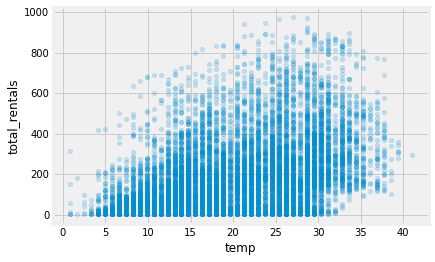

In [15]:
# Pandas scatterplot
df.plot(kind='scatter', x='temp', y='total_rentals', alpha=0.2);

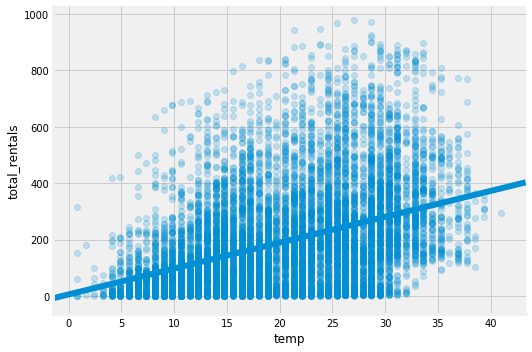

In [16]:
# Seaborn scatterplot with regression line
sns.lmplot(x='temp', y='total_rentals', data=df, aspect=1.5, scatter_kws={'alpha':0.2});

<a id="linear-regression-basics"></a>
## Linear Regression Basics
---

<a id="form-of-linear-regression"></a>
### Form of Linear Regression

Recall that each model always contains some amount of random irreducible error $\epsilon$. So, given a prediction $\hat{y}$, the actual $y = \hat{y} + \epsilon$. Below, we will assume $y$ is exactly linear.

- We are often taught the formula for a line is: $y = mx + b$.
- Note this can alternatively be written: $y = \alpha + \beta X$.

---

Here, we will generalize this to $n$ independent variables as follows:

$y = \beta_0 + \beta_1x_1 + \beta_2x_2 + ... + \beta_nx_n + \epsilon$

- $y$ is the response.
- $\beta_0$ is the intercept.
- $\beta_1$ is the coefficient for $x_1$ (the first feature).
- $\beta_n$ is the coefficient for $x_n$ (the nth feature).
- $\epsilon$ is the _error_ term

A practical example of this applied to our data might be:

$total\_rides = 20 + -2 \cdot temp + -3 \cdot windspeed\ +\ ...\ +\ 0.1 \cdot registered$

This equation is still called **linear** because the highest degree of the independent variables (e.g. $x_i$) is 1. Note that because the $\beta$ values are constants, they will not be independent variables in the final model, as seen above.

---

The $\beta$ values are called the **model coefficients**:

- These values are estimated (or "learned") during the model fitting process using the **least squares criterion**.
- Specifically, we are trying to find the line (mathematically) that minimizes the **sum of squared residuals** (or "sum of squared errors").
- Once we've learned these coefficients, we can use the model to predict the response.

![Estimating coefficients](../assets/estimating_coefficients.png)

In the diagram above:

- The black dots are the **observed values** of x and y.
- The blue line is our **least squares line**.
- The red lines are the **residuals**, which are the vertical distances between the observed values and the least squares line.

<a id="overview-of-supervised-learning"></a>
## Overview of Supervised Learning
---

![Supervised learning diagram](../assets/supervised_learning.png)

<a id="benefits-and-drawbacks-of-scikit-learn"></a>
### Benefits and Drawbacks of scikit-learn

**Benefits:**

- Consistent interface to machine learning models.
- Provides many tuning parameters but with sensible defaults.
- Exceptional documentation.
- Rich set of functionality for companion tasks.
- Active community for development and support.

**Potential drawbacks:**

- Harder (than R) to get started with machine learning.
- Less emphasis (than R) on model interpretability.
    - scikit-learn tends not to run detailed statistical tests, e.g. ANOVA.
    - For more detail on model fit, try the `statsmodels` library.

Ben Lorica: [Six Reasons Why I Recommend scikit-learn](http://radar.oreilly.com/2013/12/six-reasons-why-i-recommend-scikit-learn.html)

<a id="requirements-for-working-with-data-in-scikit-learn"></a>
### Requirements for Working With Data in scikit-learn

1. Features and response should be separate objects.
2. Features and response should be entirely numeric.
3. Features and response should be NumPy arrays (or easily converted to NumPy arrays).
4. Features and response should have specific shapes (outlined below).

<a id="building-a-linear-regression-model-in-sklearn"></a>
### Building a Linear Regression Model in sklearn

#### Create a feature matrix called "X" that holds a `DataFrame` with only the "temp" variable and a `Series` called y that has the "total_rentals" column.

In [17]:
# Create X and y.
feature_cols = ['temp']

X = df[feature_cols]
y = df.total_rentals

In [18]:
# Check X's type.
print((type(X)))
print((type(X.values)))

<class 'pandas.core.frame.DataFrame'>
<class 'numpy.ndarray'>


In [19]:
# Check y's type.
print((type(y)))
print((type(y.values)))

<class 'pandas.core.series.Series'>
<class 'numpy.ndarray'>


In [20]:
# Check X's shape (n = number of observations, p = number of features).
print((X.shape))

(10886, 1)


In [21]:
# Check y's shape (single dimension with length n).
# The comma indicates the datatype is a tuple.
print((y.shape))

(10886,)


<a id="scikit-learns--step-modeling-pattern"></a>
### scikit-learn's Four-Step Modeling Pattern

**Step 1:** Import the class you plan to use.

In [22]:
from sklearn.linear_model import LinearRegression

**Step 2:** "Instantiate" the "estimator."

- "Estimator" is scikit-learn's term for "model."
- "Instantiate" means "make an instance of."

In [23]:
# Make an instance of a LinearRegression object.
lr = LinearRegression()
type(lr)

sklearn.linear_model.base.LinearRegression

- Created an object that "knows" how to do linear regression, and is just waiting for data.
- Name of the object does not matter.
- All parameters not specified are set to their defaults.
- Can specify tuning parameters (aka "hyperparameters") during this step. 

To view the possible parameters, either use the `help` built-in function or evaluate the newly instantiated model, as follows:

In [24]:
# help(lr)
lr

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

**Step 3:** Fit the model with data (aka "model training").

- Model is "learning" the relationship between X and y in our "training data."
- Process through which learning occurs varies by model.
- Occurs in-place.

In [25]:
lr.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

- Once a model has been fit with data, it's called a "fitted model."

**Step 4:** Predict the response for a new observation.

- New observations are called "out-of-sample" data.
- Uses the information it learned during the model training process.

In [26]:
# Per future warning, one-dimensional arrays must be reshaped using the following.
lr.predict(np.array([0]).reshape(1,-1))

array([6.04621296])

- Returns a NumPy array, and we keep track of what the numbers "mean."
- Can predict for multiple observations at once.

In [27]:
### reshape function in NumPy for one-dimensional arrays
import numpy as np

z = np.array([[1, 2, 3, 4],
         [5, 6, 7, 8],
         [9, 10, 11, 12]])
z.shape
(3, 4)

(3, 4)

In [28]:
# Now trying to reshape with (-1) . Result new shape is (12,) and is compatible with original shape (3,4)
z.reshape(-1)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

In [29]:
# Now trying to reshape with (-1, 1) . We have provided column as 1 but rows as unknown . 
# So we get result new shape as (12, 1).again compatible with original shape(3,4)

z.reshape(-1,1)

array([[ 1],
       [ 2],
       [ 3],
       [ 4],
       [ 5],
       [ 6],
       [ 7],
       [ 8],
       [ 9],
       [10],
       [11],
       [12]])

Let's ask the model to make two predictions, one when the `temp` is 0 and another when the `temp` is 10. To do this, our feature matrix is always a 2-D array where each row is a list of features. Since we only have a single feature, the temperature, each row will contain only a single value.

In [30]:
X_new = [[0], [10]]
lr.predict(X_new)

array([ 6.04621296, 97.75161777])

What we just predicted using our model is, "If the temperature is 0 degrees, the total number of bike rentals will be ~6.046, and if the temperature is 10 degrees the total number of bike rentals will ~97.751."

<a id="build-a-linear-regression-model"></a>
## Build a Linear Regression Model
---

#### Instantiate and fit a `LinearRegression` model on X and y from the `linear_model` section of scikit-learn.

In [31]:
# Import, instantiate, fit.
from sklearn.linear_model import LinearRegression
linreg = LinearRegression()
linreg.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

#### Explore the intercept and coefficients of the linear model

You can search for "sklearn linear regression" and explore the attributes section of the documentation to learn how to do this.

In [32]:
# Print the coefficients.
print(linreg.intercept_)
print(linreg.coef_)

6.046212959616781
[9.17054048]


Interpreting the intercept ($\beta_0$):

- It is the value of $y$ when all independent variables are 0.
- Here, it is the estimated number of rentals when the temperature is 0 degrees Celsius.
- **Note:** It does not always make sense to interpret the intercept. (Why?)

Interpreting the "temp" coefficient ($\beta_1$):

- **Interpretation:** An increase of 1 degree Celcius is _associated with_ increasing the number of total rentals by $\beta_1$.
- Here, a temperature increase of 1 degree Celsius is _associated with_ a rental increase of 9.17 bikes.
- This is not a statement of causation.
- $\beta_1$ would be **negative** if an increase in temperature was associated with a decrease in total rentals.
- $\beta_1$ would be **zero** if temperature is not associated with total rentals.

<a id="using-the-model-for-prediction"></a>
## Using the Model for Prediction
---

While plenty of insight can be found in reading coefficients, the most common uses of data science focus on prediction. In scikit-learn we can make predictions from a fitted model using `.predict()`, but we will also go through the calculation by hand to understand it.

#### How many bike rentals would we predict if the temperature was 25 degrees Celsius?

In [33]:
# Manually calculate the prediction.
linreg.intercept_ + linreg.coef_*25

array([235.309725])

In [34]:
# Use the predict method.
linreg.predict(np.array([25]).reshape(1,-1))

array([235.309725])

<a id="does-the-scale-of-the-features-matter"></a>
### Does the Scale of the Features Matter?

Let's say that temperature was measured in Fahrenheit, rather than Celsius. How would that affect the model?

In [36]:
# Create a new column for Fahrenheit temperature.
df['temp_F'] = df.temp * 1.8 + 32
df.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,total_rentals,year,month,day,dayofweek,hour,temp_F
datetime,,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,5,0,49.712
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,5,1,48.236
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,5,2,48.236
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,1,5,3,49.712
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,1,5,4,49.712


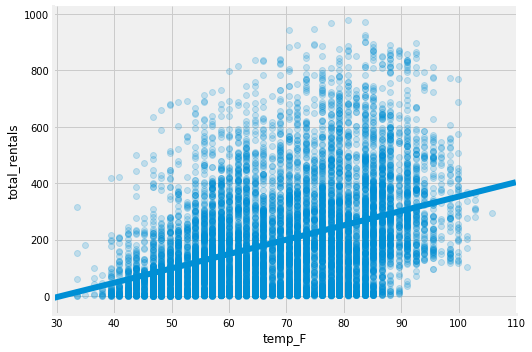

In [37]:
# Seaborn scatterplot with regression line
sns.lmplot(x='temp_F', y='total_rentals', data=df, aspect=1.5, scatter_kws={'alpha':0.2});

#### Rebuild the LinearRegression from above using the temp_F features instead.

In [38]:
# Create X and y.
feature_cols = ['temp_F']
X = df[feature_cols]
y = df.total_rentals

# Instantiate and fit.
linreg = LinearRegression()
linreg.fit(X, y)

# Print the coefficients.
print(linreg.intercept_)
print(linreg.coef_)

-156.98561782129445
[5.09474471]


#### Convert 25 degrees Celsius to Fahrenheit.

In [39]:
25 * 1.8 + 32

77.0

#### Predict rentals for 77 degrees Fahrenheit.

In [40]:
linreg.predict(np.array([77]).reshape(1,-1))

array([235.309725])

**Conclusion:** The scale of the features is irrelevant for linear regression models. When changing the scale, we simply change our interpretation of the coefficients.

In [41]:
# Remove the temp_F column.
df.drop('temp_F', axis=1, inplace=True)

<a id="work-with-multiple-features"></a>
## Work With Multiple Features
---

We've demonstrated simple linear regression with one feature to gain an intuition, but the benefit of modeling is the ability to reason about hundreds of features at once. There is no limit to the number of features you can use. However, often a small set of features accounts for most of the variance (assuming there is a linear relationship at all). We will start by using four features.

<a id="visualizing-the-data-part-"></a>
### Visualizing the Data (Part 2)

#### Explore more features.

In [42]:
# Create feature column variables
feature_cols = ['temp', 'season', 'weather', 'humidity']

#### Create a subset of scatterplot matrix using Seaborn.
We can use pairplot with the `y_vars` argument to only show relationships with the `total_rentals` variable

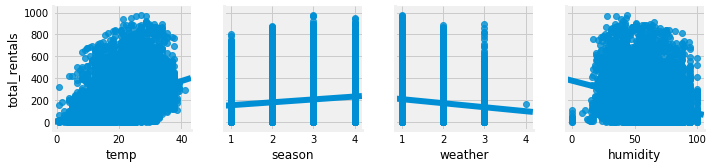

In [43]:
# Multiple scatterplots in Seaborn
sns.pairplot(df, x_vars=feature_cols, y_vars='total_rentals', kind='reg');

#### Recreate the same functionality using Pandas.

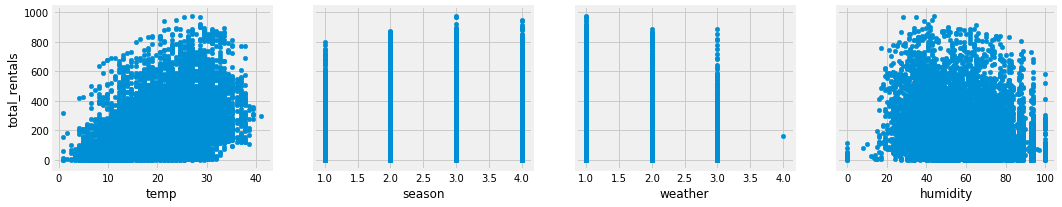

In [44]:
# Multiple scatterplots in Pandas
fig, axs = plt.subplots(1, len(feature_cols), sharey=True)
for index, feature in enumerate(feature_cols):
    df.plot(kind='scatter', x=feature, y='total_rentals', ax=axs[index], figsize=(16, 3))

Example below from https://www.geeksforgeeks.org/enumerate-in-python/

In [45]:
# enumerate function 
l1 = ["eat","sleep","repeat"] 
s1 = "geek"
  
# creating enumerate objects 
obj1 = enumerate(l1) 
obj2 = enumerate(s1) 
  
print("Return type:",type(obj1) )
print(list(enumerate(l1))) 
  
# changing start index to 2 from 0 
print(list(enumerate(s1,2)))

Return type: <class 'enumerate'>
[(0, 'eat'), (1, 'sleep'), (2, 'repeat')]
[(2, 'g'), (3, 'e'), (4, 'e'), (5, 'k')]


#### Are you seeing anything you didn't expect?

#### Explore the season variable using a cross-tab.

In [47]:
# Cross-tabulation of season and month
pd.crosstab(df.season, df.index.month)

col_0,1,2,3,4,5,6,7,8,9,10,11,12
season,,,,,,,,,,,,
1,884,901,901,0,0,0,0,0,0,0,0,0
2,0,0,0,909,912,912,0,0,0,0,0,0
3,0,0,0,0,0,0,912,912,909,0,0,0
4,0,0,0,0,0,0,0,0,0,911,911,912


#### Explore the season variable using a box plot.

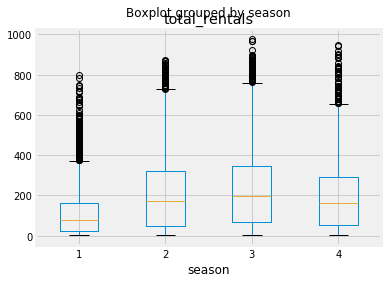

In [48]:
# Box plot of rentals, grouped by season.
df.boxplot(column='total_rentals', by='season');

Notably:

- A line can't capture a nonlinear relationship.

#### Look at rentals over time.

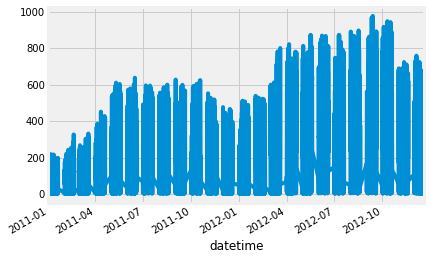

In [49]:
# Line plot of rentals
df.total_rentals.plot();

#### What does this tell us?

There are more rentals in the winter than the spring, but only because the system is experiencing overall growth and the winter months happen to come after the spring months.

#### Look at the correlation matrix for the bikes `DataFrame`.

In [50]:
# Correlation matrix (ranges from 1 to -1)
df.corr()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,total_rentals,year,month,day,dayofweek,hour
season,1.000000,0.029368,-0.008126,0.008879,0.258689,0.264744,0.190610,-0.147121,0.096758,0.164011,0.163439,-0.004797,0.971524,0.001729,-0.010553,-0.006546
holiday,0.029368,1.000000,-0.250491,-0.007074,0.000295,-0.005215,0.001929,0.008409,0.043799,-0.020956,-0.005393,0.012021,0.001731,-0.015877,-0.191832,-0.000354
workingday,-0.008126,-0.250491,1.000000,0.033772,0.029966,0.024660,-0.010880,0.013373,-0.319111,0.119460,0.011594,-0.002482,-0.003394,0.009829,-0.704267,0.002780
weather,0.008879,-0.007074,0.033772,1.000000,-0.055035,-0.055376,0.406244,0.007261,-0.135918,-0.109340,-0.128655,-0.012548,0.012144,-0.007890,-0.047692,-0.022740
temp,0.258689,0.000295,0.029966,-0.055035,1.000000,0.984948,-0.064949,-0.017852,0.467097,0.318571,0.394454,0.061226,0.257589,0.015551,-0.038466,0.145430
atemp,0.264744,-0.005215,0.024660,-0.055376,0.984948,1.000000,-0.043536,-0.057473,0.462067,0.314635,0.389784,0.058540,0.264173,0.011866,-0.040235,0.140343
humidity,0.190610,0.001929,-0.010880,0.406244,-0.064949,-0.043536,1.000000,-0.318607,-0.348187,-0.265458,-0.317371,-0.078606,0.204537,-0.011335,-0.026507,-0.278011
windspeed,-0.147121,0.008409,0.013373,0.007261,-0.017852,-0.057473,-0.318607,1.000000,0.092276,0.091052,0.101369,-0.015221,-0.150192,0.036157,-0.024804,0.146631
casual,0.096758,0.043799,-0.319111,-0.135918,0.467097,0.462067,-0.348187,0.092276,1.000000,0.497250,0.690414,0.145241,0.092722,0.014109,0.246959,0.302045
registered,0.164011,-0.020956,0.119460,-0.109340,0.318571,0.314635,-0.265458,0.091052,0.497250,1.000000,0.970948,0.264265,0.169451,0.019111,-0.084427,0.380540


#### Use a heat map to make it easier to read the correlation matrix.

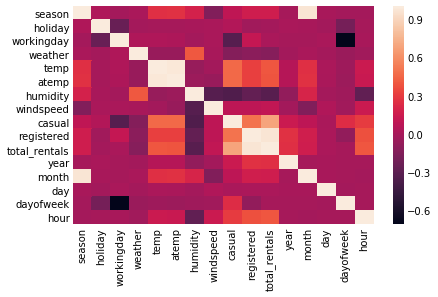

In [51]:
# Visualize correlation matrix in Seaborn using a heat map.
sns.heatmap(df.corr())

#### What relationships do you notice?

In [ ]:
# We tend to have more ridership with lower humidity.
# We tend to have more ridership with higher temperature.

<a id="adding-more-features-to-the-model"></a>
### Adding More Features to the Model

In the previous example, one variable explained the variance of another; however, more often than not, we will need multiple variables. 

- For example, a house's price may be best measured by square feet, but a lot of other variables play a vital role: bedrooms, bathrooms, location, appliances, etc. 

- For a linear regression, we want these variables to be largely independent of one another, but all of them should help explain the y variable.

We'll work with bikeshare data to showcase what this means and to explain a concept called multicollinearity.

#### Create another `LinearRegression` instance that is fit using "temp", "season", "weather", and "humidity".

In [ ]:
# Create a list of features.
feature_cols = ['temp', 'season', 'weather', 'humidity']

In [52]:
# Create X and y.
X = df[feature_cols]
y = df.total_rentals

# Instantiate and fit.
linreg = LinearRegression()
linreg.fit(X, y)

# Print the coefficients.
print(linreg.intercept_)
print(linreg.coef_)

159.52068786129817
[ 7.86482499 22.53875753  6.67030204 -3.11887338]


#### Display the linear regression coefficient along with the feature names.

In [53]:
# Pair the feature names with the coefficients.
list(zip(feature_cols, linreg.coef_))

[('temp', 7.864824992477439),
 ('season', 22.53875753246676),
 ('weather', 6.670302035923719),
 ('humidity', -3.118873382396501)]

Interpreting the coefficients:

- Holding all other features fixed, a 1-unit increase in temperature is associated with a rental increase of 7.86 bikes.
- Holding all other features fixed, a 1-unit increase in season is associated with a rental increase of 22.5 bikes.
- Holding all other features fixed, a 1-unit increase in weather is associated with a rental increase of 6.67 bikes.
- Holding all other features fixed, a 1-unit increase in humidity is associated with a rental decrease of 3.12 bikes.

Does anything look incorrect and does not reflect reality?

<a id="what-is-multicollinearity"></a>
## What Is Multicollinearity?
---

Multicollinearity happens when two or more features are highly correlated with each other. The problem is that due to the high correlation, it's hard to disambiguate which feature has what kind of effect on the outcome. In other words, the features mask each other. 

There is a second related issue called variance inflation where including correlated features increases the variability of our model and p-values by widening the standard errors. This can be measured with the variance inflation factor, which we will not cover here.

#### With the bikeshare data, let's compare three data points: actual temperature, "feel" temperature, and guest ridership.

            temp     atemp    casual
temp    1.000000  0.984948  0.467097
atemp   0.984948  1.000000  0.462067
casual  0.467097  0.462067  1.000000
AxesSubplot(0.08,0.125;0.696x0.755)


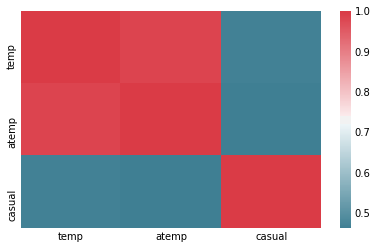

In [54]:
cmap = sns.diverging_palette(220, 10, as_cmap=True)
correlations = df[['temp', 'atemp', 'casual']].corr()
print(correlations)
print(sns.heatmap(correlations, cmap=cmap))

#### Create a linear model that predict `total_rentals` using `temp` and `atemp`.

In [ ]:
# Create a list of features.
feature_cols = ['temp', 'atemp']

In [55]:
# Create X and y.
X = df[feature_cols]
y = df.total_rentals

# Instantiate and fit.
linreg = LinearRegression()
linreg.fit(X, y)

# Print the coefficients.
print(linreg.intercept_)
print(linreg.coef_)

159.52068786129817
[ 7.86482499 22.53875753  6.67030204 -3.11887338]


#### Go back and remove either `temp` or `atemp` from the feature list. How do the coefficients change? 

            temp    casual
temp    1.000000  0.467097
casual  0.467097  1.000000
AxesSubplot(0.08,0.125;0.696x0.755)


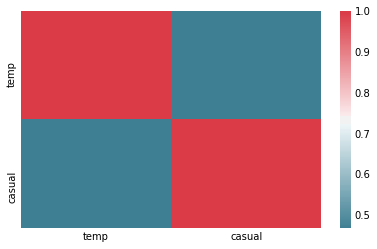

In [56]:
cmap = sns.diverging_palette(220, 10, as_cmap=True)
correlations = df[['temp', 'casual']].corr()
print(correlations)
print(sns.heatmap(correlations, cmap=cmap))

In [57]:
# Create a list of features.
feature_cols = ['temp']

# Create X and y.
X = df[feature_cols]
y = df.total_rentals

# Instantiate and fit.
linreg = LinearRegression()
linreg.fit(X, y)

# Print the coefficients.
print(linreg.intercept_)
print(linreg.coef_)

6.046212959616781
[9.17054048]


In [ ]:
# The feeling temperature and actual temperature are highly correlated 
# and mask each other's effects when both included in the regression.

<a id="how-to-select-a-model"></a>
## How to Select a Model
---

We can make linear models now, but how do we select the best model to use for our applications? We will offer a general procedure and a simple metric that works well in many cases. That said, it's important to keep the business context in mind and know that there are alternative metrics that can work better.

<a id="feature-selection"></a>
### Feature Selection

How do we choose which features to include in the model? We're going to use **train/test split** (and eventually **cross-validation**).

Why not use p-values or R-squared for feature selection?

- Linear models rely upon a lot of assumptions (such as the features being independent), and if those assumptions are violated, p-values and R-squared are less reliable. Train/test split relies on fewer assumptions.
- If all of the assumptions of a linear model are met, p-values suggest a coefficient that differs from zero at a level of statistical significance. This does not mean that
    1. the feature _causes_ the response
    2. the feature strongly _predicts_ the response. 
- Adding features to your model that are unrelated to the response will always increase the R-squared value, and adjusted R-squared does not sufficiently account for this (although, AIC and BIC do).
- p-values and R-squared are **proxies** for our goal of generalization, whereas train/test split and cross-validation attempt to directly estimate how well the model will generalize to out-of-sample data.

More generally:

- There are different methodologies that can be used for solving any given data science problem, and this course follows a machine learning methodology.
- This course focuses on general purpose approaches that can be applied to any model, rather than model-specific approaches.

<a id="evaluation-metrics-for-regression-problems"></a>
### Evaluation Metrics for Regression Problems

Evaluation metrics for classification problems, such as accuracy, are not useful for regression problems. We need evaluation metrics designed for comparing continuous values.

Here are three common evaluation metrics for regression problems:

**Mean absolute error (MAE)** is the mean of the absolute value of the errors:

$$\frac 1n\sum_{i=1}^n|y_i-\hat{y}_i|$$

**Mean squared error (MSE)** is the mean of the squared errors:

$$\frac 1n\sum_{i=1}^n(y_i-\hat{y}_i)^2$$

**Root mean squared error (RMSE)** is the square root of the mean of the squared errors:

$$\sqrt{\frac 1n\sum_{i=1}^n(y_i-\hat{y}_i)^2}$$

In [59]:
# Example true and predicted response values
true = [10, 7, 5, 5]
pred = [8, 6, 5, 10]

#### Calculate MAE, MSE, and RMSE using imports from sklearn metrics and NumPy.

In [60]:
# Calculate these metrics by hand!
from sklearn import metrics
import numpy as np
print('MAE:', metrics.mean_absolute_error(true, pred))
print('MSE:', metrics.mean_squared_error(true, pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(true, pred)))

MAE: 2.0
MSE: 7.5
RMSE: 2.7386127875258306


Let's compare these metrics:

- MAE is the easiest to understand, because it's the average error.
- MSE is more popular than MAE, because MSE "punishes" larger errors, which tends to be useful in the real world.Also, MSE is continuous and differentiable, making it easier to use than MAE for optimization.
- RMSE is even more popular than MSE, because RMSE is interpretable in the "y" units.

All of these are **loss functions**, because we want to minimize them.

Here's an additional example, to demonstrate how MSE/RMSE punishes larger errors:

In [61]:
# Same true values as above
true = [10, 7, 5, 5]

# New set of predicted values
pred = [10, 7, 5, 13]

# MAE is the same as before.
print('MAE:', metrics.mean_absolute_error(true, pred))

# MSE and RMSE are larger than before.
print('MSE:', metrics.mean_squared_error(true, pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(true, pred)))

MAE: 2.0
MSE: 16.0
RMSE: 4.0


## Introducing train_test_split

#### Basic example

In [62]:
from sklearn.model_selection import train_test_split

In [63]:
X, y = np.arange(10).reshape((5, 2)), range(5)

In [64]:
X

array([[0, 1],
       [2, 3],
       [4, 5],
       [6, 7],
       [8, 9]])

In [65]:
list(y)

[0, 1, 2, 3, 4]

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [67]:
X_train

array([[4, 5],
       [0, 1],
       [6, 7]])

In [68]:
y_train

[2, 0, 3]

In [69]:
X_test

array([[2, 3],
       [8, 9]])

In [70]:
y_test

[1, 4]

In [71]:
train_test_split(y, shuffle=False)

[[0, 1, 2], [3, 4]]

In [72]:
linreg = LinearRegression()

# training data ONLY!!!
linreg.fit(X_train, y_train)

# Test data for predictions!
y_pred = linreg.predict(X_test)

In [73]:
y_pred

array([1., 4.])

In [74]:
y_test

[1, 4]

#### Bike example

In [75]:
from sklearn.model_selection import train_test_split

# Create a list of features.
feature_cols = ['temp']

In [76]:
# Create X and y.
X = df[feature_cols]
y = df.total_rentals

In [77]:
# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [78]:
print('training features: ', X_train.shape)
print('training target: ', y_train.shape)
print('testing features: ', X_test.shape)
print('testing target: ', y_test.shape)

training features:  (7293, 1)
training target:  (7293,)
testing features:  (3593, 1)
testing target:  (3593,)


In [79]:
# Instantiage
linreg = LinearRegression()

In [80]:
linreg

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [81]:
# Fit
linreg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [82]:
# Predict
y_pred = linreg.predict(X_test)

In [83]:
# Evaluate (score)
(y_test - y_pred).head()

datetime
2011-07-19 11:00:00   -186.108243
2012-01-16 06:00:00    -32.311364
2011-12-11 18:00:00     65.617020
2012-08-15 10:00:00    -42.914232
2012-06-15 23:00:00    -16.720221
Name: total_rentals, dtype: float64

In [84]:
# RMSE
np.sqrt(metrics.mean_squared_error(y_test, y_pred))

164.63555851037526

<a id="comparing-models-with-traintest-split-and-rmse"></a>
### Comparing Models With Train/Test Split and RMSE

In [85]:
from sklearn.model_selection import train_test_split

# Define a function that accepts a list of features and returns testing RMSE.
def train_test_rmse(df, feature_cols):
    X = df[feature_cols]
    y = df.total_rentals
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123)
    
    linreg = LinearRegression()
    linreg.fit(X_train, y_train)
    
    y_pred = linreg.predict(X_test)
    return np.sqrt(metrics.mean_squared_error(y_test, y_pred))

In [86]:
# Compare different sets of features.
print(train_test_rmse(df, ['temp', 'season', 'weather', 'humidity']))
print(train_test_rmse(df, ['temp', 'season', 'weather']))
print(train_test_rmse(df, ['temp', 'season', 'humidity']))

155.64945913079674
164.1653997629182
155.59818936691417


In [88]:
# Using these as features is not allowed!
print(train_test_rmse(df, ['casual', 'registered']))

6.465079976076669e-14


<a id="comparing-testing-rmse-with-null-rmse"></a>
### Comparing Testing RMSE With Null RMSE

Null RMSE is the RMSE that could be achieved by always predicting the mean response value. It is a benchmark against which you may want to measure your regression model.

In [89]:
# Split X and y into training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123)

# Create a NumPy array with the same shape as y_test.
y_null = np.zeros_like(y_test, dtype=float)

# Fill the array with the mean value of y_test.
y_null.fill(y_test.mean())
y_null

array([192.26451139, 192.26451139, 192.26451139, ..., 192.26451139,
       192.26451139, 192.26451139])

In [90]:
# Compute null RMSE.
np.sqrt(metrics.mean_squared_error(y_test, y_null))

179.57906896465727

<a id="feature-engineering-to-improve-performance"></a>
## Feature Engineering to Improve Performance
---

Machine learning models are very powerful, but they cannot automatically handle every aspect of our data. We have to explicitly modify our features to have relationships that our models can understand. In this case, we will need to pull out features to have a linear relationship with our response variable.

<a id="handling-categorical-features"></a>
### Handling Categorical Features

scikit-learn expects all features to be numeric. So how do we include a categorical feature in our model?

- **Ordered categories:** Transform them to sensible numeric values (example: small=1, medium=2, large=3)
- **Unordered categories:** Use dummy encoding (0/1). Here, each possible category would become a separate feature.

What are the categorical features in our data set?

- **Ordered categories:** `weather` (already encoded with sensible numeric values)
- **Unordered categories:** `season` (needs dummy encoding), `holiday` (already dummy encoded), `workingday` (already dummy encoded)

For season, we can't simply leave the encoding as 1 = spring, 2 = summer, 3 = fall, and 4 = winter, because that would imply an ordered relationship. Instead, we create multiple dummy variables.

#### Create dummy variables using `get_dummies` from Pandas.

In [91]:
season_dummies = pd.get_dummies(df.season, prefix='season')

#### Inspect the `DataFrame` of `dummies`.

In [92]:
# Print five random rows.
season_dummies.sample(n=5, random_state=1)

,season_1,season_2,season_3,season_4
datetime,,,,
2011-09-05 11:00:00,0,0,1,0
2012-03-18 04:00:00,1,0,0,0
2012-10-14 17:00:00,0,0,0,1
2011-04-04 15:00:00,0,1,0,0
2012-12-11 02:00:00,0,0,0,1


However, we actually only need three dummy variables (not four), and thus we'll drop the first dummy variable.

Why? Because three dummies captures all of the "information" about the season feature, and implicitly defines spring (season 1) as the baseline level.

This circles back to the concept multicollinearity, except instead of one feature being highly correlated to another, the information gained from three features is directly correlated to the fourth.

#### Drop the first column.

In [93]:
season_dummies.drop(season_dummies.columns[0], axis=1, inplace=True)

#### Reinspect the `DataFrame` of `dummies`.

In [94]:
# Print five random rows.
season_dummies.sample(n=5, random_state=1)

,season_2,season_3,season_4
datetime,,,
2011-09-05 11:00:00,0,1,0
2012-03-18 04:00:00,0,0,0
2012-10-14 17:00:00,0,0,1
2011-04-04 15:00:00,1,0,0
2012-12-11 02:00:00,0,0,1


In general, if you have a categorical feature with k possible values, you create k-1 dummy variables.

If that's confusing, think about why we only need one dummy variable for `holiday`, not two dummy variables (`holiday_yes` and `holiday_no`).

#### We now need to concatenate the two `DataFrames` together.

In [97]:
# Concatenate the original DataFrame and the dummy DataFrame (axis=0 means rows, axis=1 means columns).
bikes_dummies = pd.concat([df, season_dummies], axis=1)

# Print five random rows.
bikes_dummies.sample(n=5, random_state=1)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,total_rentals,year,month,day,dayofweek,hour,season_2,season_3,season_4
datetime,,,,,,,,,,,,,,,,,,,
2011-09-05 11:00:00,3,1,0,2,28.70,33.335,74,11.0014,101,207,308,2011,9,5,0,11,0,1,0
2012-03-18 04:00:00,1,0,0,2,17.22,21.210,94,11.0014,6,8,14,2012,3,18,6,4,0,0,0
2012-10-14 17:00:00,4,0,0,1,26.24,31.060,44,12.9980,193,346,539,2012,10,14,6,17,0,0,1
2011-04-04 15:00:00,2,0,1,1,31.16,33.335,23,36.9974,47,96,143,2011,4,4,0,15,1,0,0
2012-12-11 02:00:00,4,0,1,2,16.40,20.455,66,22.0028,0,1,1,2012,12,11,1,2,0,0,1


#### Rerun the linear regression with dummy variables included.

In [98]:
# Include dummy variables for season in the model.
feature_cols = ['temp', 'season_2', 'season_3', 'season_4', 'humidity']
X = bikes_dummies[feature_cols]
y = bikes_dummies.total_rentals

linreg = LinearRegression()
linreg.fit(X, y)

list(zip(feature_cols, linreg.coef_))

[('temp', 11.186405863575784),
 ('season_2', -3.3905430997179598),
 ('season_3', -41.73686071317068),
 ('season_4', 64.41596146824214),
 ('humidity', -2.819481636259646)]

How do we interpret the season coefficients? They are measured against the baseline (spring):

- Holding all other features fixed, summer is associated with a rental decrease of 3.39 bikes compared to the spring.
- Holding all other features fixed, fall is associated with a rental decrease of 41.7 bikes compared to the spring.
- Holding all other features fixed, winter is associated with a rental increase of 64.4 bikes compared to the spring.

Would it matter if we changed which season was defined as the baseline?

- No, it would simply change our interpretation of the coefficients.

In most situations, it is best to have your baseline be the category that has the largest representation.

**Important:** Dummy encoding is relevant for all machine learning models, not just linear regression models.

In [99]:
# Compare original season variable with dummy variables.
print(train_test_rmse(bikes_dummies, ['temp', 'season', 'humidity']))
print(train_test_rmse(bikes_dummies, ['temp', 'season_2', 'season_3', 'season_4', 'humidity']))

155.59818936691417
154.33394593635998


<a id="feature-engineering"></a>
### Feature Engineering

See if you can create the following features:

- **hour:** as a single numeric feature (0 through 23)
- **hour:** as a categorical feature (use 23 dummy variables)
- **daytime:** as a single categorical feature (daytime=1 from 7 a.m. to 8 p.m., and daytime=0 otherwise)

Then, try using each of the three features (on its own) with `train_test_rmse` to see which one performs the best!

#### Extract hour of the day to use as a feature.

In [100]:
df['hour'] = df.index.hour

#### Encode `hour` as a categorical feature.

In [102]:
hour_dummies = pd.get_dummies(df.hour, prefix='hour')
hour_dummies.drop(hour_dummies.columns[0], axis=1, inplace=True)
bikes = pd.concat([df, hour_dummies], axis=1)

In [103]:
bikes.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,...,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
datetime,,,,,,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,...,0,0,0,0,0,0,0,0,0,0
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,...,0,0,0,0,0,0,0,0,0,0
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,...,0,0,0,0,0,0,0,0,0,0
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,...,0,0,0,0,0,0,0,0,0,0
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,...,0,0,0,0,0,0,0,0,0,0


#### Generate a `daytime` variable based on hour of the day.

In [104]:
bikes['daytime'] = ((bikes.hour > 6) & (bikes.hour < 21)).astype(int)

#### Test the root mean squared error of our various `hour` encodings.

In [105]:
print(train_test_rmse(bikes, ['hour']))
print(train_test_rmse(bikes, bikes.columns[bikes.columns.str.startswith('hour_')]))
print(train_test_rmse(bikes, ['daytime']))

165.67174264111398
128.3112050281119
144.89116360237938


<a id="bonus-material-regularization"></a>
## Bonus Material: Regularization
---

- Regularization is a method for "constraining" or "regularizing" the size of the coefficients, thus "shrinking" them toward zero.
- It reduces model variance and thus minimizes overfitting.
- If the model is too complex, it tends to reduce variance more than it increases bias, resulting in a model that is more likely to generalize.

Our goal is to locate the optimum model complexity, and thus regularization is useful when we believe our model is too complex.

<a id="how-does-regularization-work"></a>
### How Does Regularization Work?

For a normal linear regression model, we estimate the coefficients using the least squares criterion, which minimizes the residual sum of squares (RSS).

For a regularized linear regression model, we minimize the sum of RSS and a "penalty term" that penalizes coefficient size.

**Ridge regression** (or "L2 regularization") minimizes: $$\text{RSS} + \alpha \sum_{j=1}^p \beta_j^2$$

**Lasso regression** (or "L1 regularization") minimizes: $$\text{RSS} + \alpha \sum_{j=1}^p |\beta_j|$$

- $p$ is the number of features.
- $\beta_j$ is a model coefficient.
- $\alpha$ is a tuning parameter:
    - A tiny $\alpha$ imposes no penalty on the coefficient size, and is equivalent to a normal linear regression model.
    - Increasing the $\alpha$ penalizes the coefficients and thus shrinks them.

<a id="lasso-and-ridge-path-diagrams"></a>
### Lasso and Ridge Path Diagrams

A larger alpha (toward the left of each diagram) results in more regularization:

- Lasso regression shrinks coefficients all the way to zero, thus removing them from the model.
- Ridge regression shrinks coefficients toward zero, but they rarely reach zero.

Source code for the diagrams: [Lasso regression](http://scikit-learn.org/stable/auto_examples/linear_model/plot_lasso_lars.html) and [Ridge regression](http://scikit-learn.org/stable/auto_examples/linear_model/plot_ridge_path.html)

![Lasso and Ridge Coefficient Plots](../assets/lasso_ridge_path.png)

<a id="advice-for-applying-regularization"></a>
### Advice for Applying Regularization

**Should features be standardized?**

- Yes, because otherwise, features would be penalized simply because of their scale.
- Also, standardizing avoids penalizing the intercept, which wouldn't make intuitive sense.

**How should you choose between lasso regression and ridge regression?**

- Lasso regression is preferred if we believe many features are irrelevant or if we prefer a sparse model.
- Ridge can work particularly well if there is a high degree of multicollinearity in your model.
- If model performance is your primary concern, it is best to try both.
- Elastic net regression is a combination of lasso regression and ridge Regression.

<a id="ridge-regression"></a>
### Ridge Regression

- [Ridge](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html) documentation
- **alpha:** must be positive, increase for more regularization
- **normalize:** scales the features (without using StandardScaler)

In [106]:
# Include dummy variables for season in the model.
feature_cols = ['temp', 'atemp', 'season_2', 'season_3', 'season_4', 'humidity']
X = bikes_dummies[feature_cols]
y = bikes_dummies.total_rentals

In [107]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [108]:
# alpha=0 is equivalent to linear regression.
from sklearn.linear_model import Ridge

# Instantiate the model.
#(Alpha of zero has no regularization strength, essentially a basic linear regression.)
ridgereg = Ridge(alpha=0, normalize=True)

# Fit the model.
ridgereg.fit(X_train, y_train)

# Predict with fitted model.
y_pred = ridgereg.predict(X_test)
print(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

156.67429349903927


In [109]:
# Coefficients for a non-regularized linear regression
list(zip(feature_cols, ridgereg.coef_))

[('temp', 8.537530902593584),
 ('atemp', 2.4548540987561642),
 ('season_2', -9.325429567785928),
 ('season_3', -40.6789961974648),
 ('season_4', 61.11748928364946),
 ('humidity', -2.865044830544153)]

To interpret these coefficients we need to convert them back to original units, which is a reason to do normalization by hand. However, in this form the coefficients have a special meaning. The intercept is now the average of our outcome, and the magnitude of each coefficient in the model is a measure of how important it is in the model. We call this feature importance.

In [110]:
# Try alpha=0.1.
ridgereg = Ridge(alpha=0.1, normalize=True)
ridgereg.fit(X_train, y_train)
y_pred = ridgereg.predict(X_test)
print(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

156.96098662565277


In [111]:
# Examine the coefficients.
list(zip(feature_cols, ridgereg.coef_))

[('temp', 5.257452659873023),
 ('atemp', 4.254523291538834),
 ('season_2', -0.17934556275242566),
 ('season_3', -21.48394260544527),
 ('season_4', 56.6822078418667),
 ('humidity', -2.658837791464091)]

While the MSE barely improved, we can see there are significant changes in the weight of our coefficients.  Particularly `season_2` whose coefficient has greatly decreased toward 0.

Fitting and using a Lasso Regression in scikit-learn is very similar.

In addition to the typical [lasso](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html) and [ridge](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html) there is a third type of regression, [Elastic Net](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html) which combines the penalties of the ridge and lasso methods.

<a id="comparing-linear-regression-with-other-models"></a>
## Comparing Linear Regression With Other Models

Advantages of linear regression:

- Simple to explain.
- Highly interpretable.
- Model training and prediction are fast.
- No tuning is required (excluding regularization).
- Features don't need scaling.
- Can perform well with a small number of observations.
- Well understood.

Disadvantages of linear regression:

- Presumes a linear relationship between the features and the response.
- Performance is (generally) not competitive with the best supervised learning methods due to high bias.
- Can't automatically learn feature interactions.